# Profile of `maze_dataset` Dumping and Loading

In [1]:

import copy
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytest
from typing import Callable

# from maze_dataset.constants import CoordArray
# from maze_dataset.dataset.dataset import (
#     register_dataset_filter,
#     register_filter_namespace_for_dataset,
# )
from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
    # register_maze_filter,
)
# from maze_dataset.maze import SolvedMaze
# from maze_dataset.utils import bool_array_from_string
# from maze_dataset.plotting import plot_dataset_mazes, print_dataset_mazes
from maze_dataset.generation.generators import GENERATORS_MAP

from maze_dataset.utils import timeit_fancy

from muutils.nbutils.configure_notebook import configure_notebook

# from zanj import ZANJ

c:\Users\Aaron\AppData\Local\pypoetry\Cache\virtualenvs\maze-dataset-zQQMZP3O-py3.10\lib\site-packages\muutils\nbutils\configure_notebook.py:12: UserWarning: Plotly not installed. Plotly plots will not be available.
  warnings.warn("Plotly not installed. Plotly plots will not be available.")


## Generate Datasets


In [10]:
cfgs = [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
                (3, 2, GENERATORS_MAP['gen_dfs'], {}, 1), 
                (5, 10, GENERATORS_MAP['gen_dfs'], dict(do_forks=False), None), 
                (5, 10, GENERATORS_MAP['gen_dfs'], {}, None), 
                # (5, 100, GENERATORS_MAP['gen_dfs'], {}, None), 
                # (5, 1000, GENERATORS_MAP['gen_dfs'], {}, None),
                # (5, 10000, GENERATORS_MAP['gen_dfs'], {}, None), 
                # (10, 1000, GENERATORS_MAP['gen_dfs'], {}, None),
                ]]
datasets = [MazeDataset.generate(cfg) for cfg in cfgs]
cfgs_small = cfgs[:3]
datasets_small = datasets[:3]

## Profile

In [11]:
columns=['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds = pd.DataFrame(np.zeros([len(cfgs), len(columns)]), columns=columns)
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

In [17]:
# zanj = ZANJ()
# d = datasets[0]
# s=d.serialize()
# p = Path(os.getcwd())/(d.cfg.to_fname()+'.zanj')
# timeit_fancy(lambda: zanj.save(s, file_path=p), namespace=locals())
# timeit_fancy(lambda: zanj.read(file_path=p), namespace=locals())
# i, rt.mazes[0].connection_list, d.mazes[0].connection_list
# configure_notebook()
i = 0
# d = datasets[i]
d = MazeDataset.from_config(MazeDatasetConfig(name='test', grid_n=3, n_mazes=2))
# cop = copy.deepcopy(d)
# for m in cop:
#     print(1)
# d.filter_by.collect_generation_meta()
# p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
# d.save(file_path=p)
d.cfg.serialize_minimal_threshold = None
# speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
# speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
# speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
# speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
# p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
# speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
# speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
d.cfg.serialize_minimal_threshold = 1
# speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
# speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
srz = d.serialize()
# d.save(file_path=p_min)
# MazeDataset.read(file_path=p_min)

ValueError: ("Cannot collect generation meta for visited_cells as it is of type '<class 'list'>'", 'expected either a basic type (bool, int, float, str), a numpy coord, or a numpy array of coords')

In [34]:
cfgs_small = cfgs[:3]
datasets_small = [MazeDataset.generate(cfg) for cfg in cfgs_small]
d = datasets_small[0]
d.cfg.serialize_minimal_threshold = None
# d.mazes[0].generation_meta
srz = d.serialize()
d.cfg.serialize_minimal_threshold = 1
# d.mazes[0].generation_meta
d.serialize()
rt = MazeDataset.load(d.serialize())
# rt.mazes[0].generation_meta is None

## Time including filtering generation metadata

In [14]:
for i, d in enumerate(datasets):
    # if i not in range(0,3): continue
    print(d.cfg)
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
    p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
    p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
    speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
    # speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None
    # rt
    # !rm {p} {p_min}
    

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_

## Time exluding filtering generation metadata

# Profiling Results

In [15]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,2,0.007584,0.025710,0.025928,0.025916,0.106456,0.119890,0.029930,0.0
1,5,10,0.007862,0.029723,0.033308,0.030877,0.124769,0.136315,0.041771,0.0
2,5,10,0.008072,0.026246,0.026763,0.022971,0.158435,0.149299,0.052890,0.0
3,5,100,0.010218,0.063074,0.076191,0.023654,0.466764,0.178632,0.390922,0.0
4,5,1000,0.029216,0.390342,0.585533,0.080996,1.278259,0.489256,2.596041,0.0
5,5,10000,0.182894,4.208587,5.468556,0.649233,10.196794,4.194346,27.211780,0.0
6,10,1000,0.034267,0.418088,0.528460,0.075361,3.254207,0.564577,8.371265,0.0


Comparing lines 4 and 6, it appears that the `grid_n` has little effect on runtimes. `serialize` and `load` runtimes scale roughly linearly with `n_mazes`.

Given that `grid_n` doesn't confound the results, the plots below show data from `speeds.loc[2:5,:]` to compare the speed of analogous procedures vs `n_mazes`. 

Text(0, 0.5, 'Runtime [sec]')

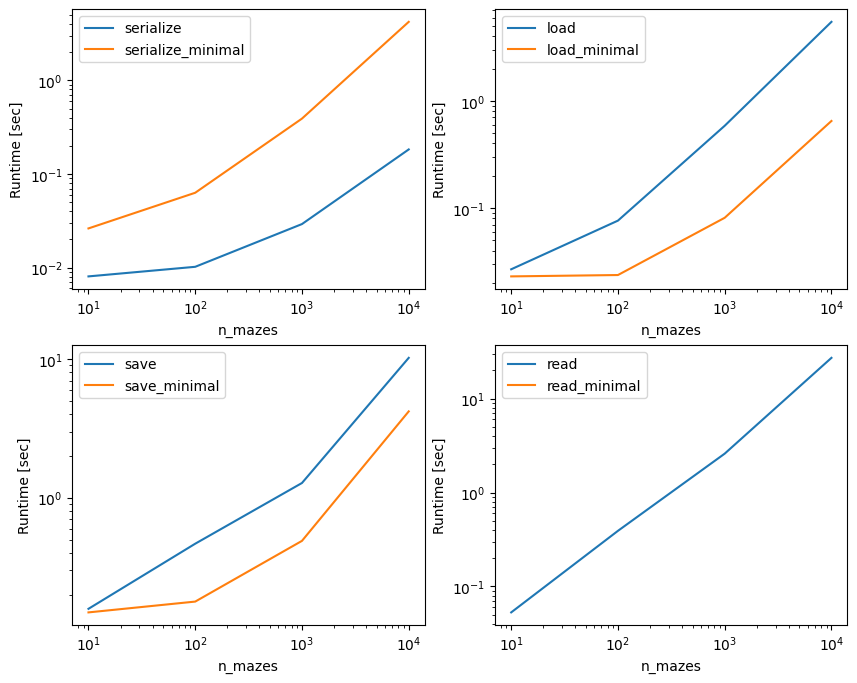

In [16]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[2:5, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[2:5, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[2]
speeds.loc[2:5, ['n_mazes', 'save', 'save_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[3]
speeds.loc[2:5, ['n_mazes', 'read', 'read_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')